# Thêm thư viện cần thiết


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [9]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/9_1/eth/ethereum_train_9_1.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.23180,0.24981,0.23085,0.24797,11970598,USD
2020-06-02,0.24801,0.25321,0.22795,0.23794,12686011,USD
2020-06-03,0.23790,0.24476,0.23384,0.24452,8151002,USD
2020-06-04,0.24453,0.24641,0.23668,0.24337,8749785,USD
2020-06-05,0.24337,0.24750,0.23970,0.24023,7754761,USD


In [10]:
train = train_ETH[["Open"]]
train.head(5)

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337


In [11]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/9_1/eth/ethereum_test_9_1.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-03-21,2.86166,2.96042,2.83038,2.89163,546607,USD
2022-03-22,2.89141,3.04832,2.88769,2.96964,716472,USD
2022-03-23,2.96964,3.04228,2.92578,3.03612,536634,USD
2022-03-24,3.03618,3.12637,3.00599,3.10925,699579,USD
2022-03-25,3.11080,3.19273,3.08171,3.10351,583248,USD


In [12]:
test = test_ETH[["Open"]]
test.head(5)

,Open
Date,
2022-03-21,2.86166
2022-03-22,2.89141
2022-03-23,2.96964
2022-03-24,3.03618
2022-03-25,3.11080


In [13]:
df = pd.concat([train.reset_index(level=0), test.reset_index(level=0)],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.index=df.Date
df.drop("Date", axis=1, inplace=True)
df.head(5)    

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337


# Vẽ đồ thị

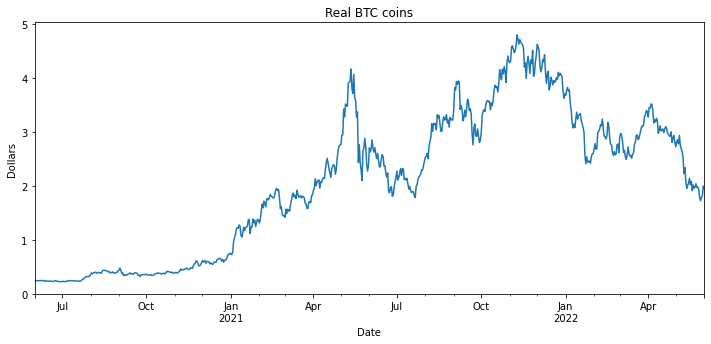

In [14]:
# Thư viện vẽ đồ thị
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real BTC coins'
ylabel='Dollars'
xlabel='Date' 

ax = df['Open'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Kiểm tra tính dừng của chuỗi

In [15]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [16]:
adf_test(df['Open'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.628066
p-value                     0.468503
Number of lags used         6.000000
Number of observations    724.000000
critical value (1%)        -3.439414
critical value (5%)        -2.865540
critical value (10%)       -2.568900
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [17]:
df['diff1'] = df['Open'].diff()
df.head()


,Open,diff1
Date,,
2020-06-01,0.23180,NaN
2020-06-02,0.24801,0.01621
2020-06-03,0.23790,-0.01011
2020-06-04,0.24453,0.00663
2020-06-05,0.24337,-0.00116


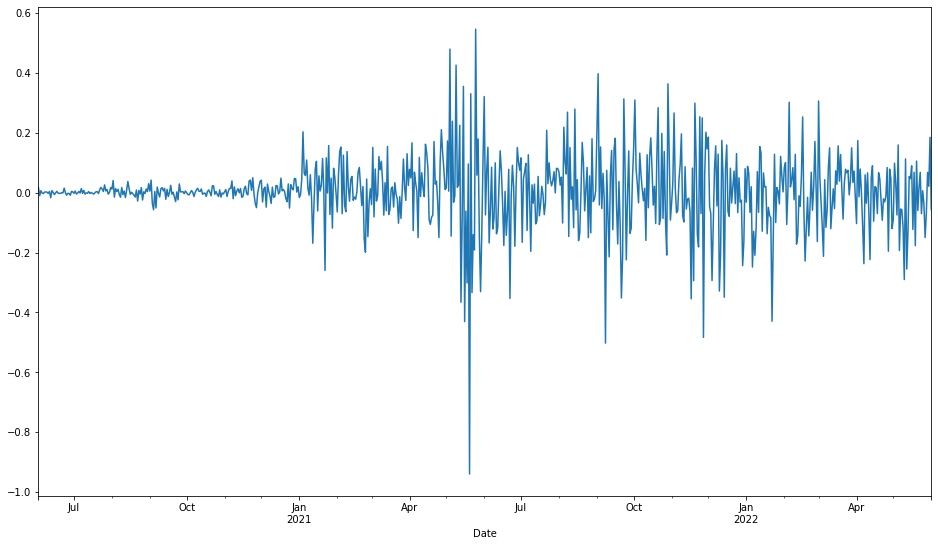

In [18]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [19]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic       -1.017531e+01
p-value                   6.917300e-18
Number of lags used       5.000000e+00
Number of observations    7.240000e+02
critical value (1%)      -3.439414e+00
critical value (5%)      -2.865540e+00
critical value (10%)     -2.568900e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [20]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Open'] = scaler.fit_transform(df_scaled['Open'].values.reshape(-1, 1))
df_scaled.head()

,Open
Date,
2020-06-01,-1.394670
2020-06-02,-1.382460
2020-06-03,-1.390075
2020-06-04,-1.385081
2020-06-05,-1.385955


## Chia dữ liệu thành tập train và tập test

In [21]:
interrupt = len(train)
interrupt

658

In [22]:
index_test = df_scaled.index[interrupt:]
print(train.shape)
print(test.shape)
print(index_test.shape)

(658, 1)
(73, 1)
(73,)


In [23]:
train.tail()

,Open
Date,
2022-03-16,2.61743
2022-03-17,2.77380
2022-03-18,2.81229
2022-03-19,2.93976
2022-03-20,2.95003


In [24]:
test.head()

,Open
Date,
2022-03-21,2.86166
2022-03-22,2.89141
2022-03-23,2.96964
2022-03-24,3.03618
2022-03-25,3.11080


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [25]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [26]:
fitted = arima_model(train)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-913.885, Time=1.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-908.772, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-912.203, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-912.059, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-910.002, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-908.579, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-908.255, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-904.829, Time=1.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-922.506, Time=1.86 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-910.066, Time=2.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-917.791, Time=4.47 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-914.975, Time=3.58 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-913.876, Time=2.62 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-916.973, Time=5.09 sec
 ARIMA(2,1,3)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  658
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 467.938
Date:                Sun, 26 Jun 2022   AIC                           -923.875
Time:                        02:28:35   BIC                           -896.949
Sample:                             0   HQIC                          -913.436
                                - 658                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8313      0.030    -60.721      0.000      -1.890      -1.772
ar.L2         -0.9112      0.029    -31.747      0.000      -0.967      -0.855
ma.L1          1.7727      0.040     44.565      0.000       1.695       1.851
ma.L2          0.8007      0.064     12.492      0.000       0.675       0.926
ma.L3         -0.0785      0.033     -2.384      0.017      -0.143      -0.014
sigma2         0.0141      0.000     32.242      0.000       0.013       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1339.57
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              37.45   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [27]:
pred = fitted.predict(len(test))
pred


array([2.96325669, 2.93774304, 2.97057459, 2.93369782, 2.97131446,
       2.936029  , 2.96637109, 2.94295771, 2.95818684, 2.95163217,
       2.94975873, 2.95916243, 2.94364824, 2.96349099, 2.94128926,
       2.96386676, 2.94275067, 2.96084802, 2.94694732, 2.95591331,
       2.95216031, 2.95086324, 2.95665845, 2.94722741, 2.95921804,
       2.94585302, 2.95940263, 2.94676736, 2.95755996, 2.94930873,
       2.95458497, 2.95244117, 2.95155931, 2.95512779, 2.94939629,
       2.95664087, 2.94859633, 2.95672711, 2.94916735, 2.95560279,
       2.95070602, 2.95380948, 2.95258809, 2.95199691, 2.95419253,
       2.95071031, 2.9550867 , 2.95024516, 2.95512374, 2.95060118,
       2.954438  , 2.9515326 , 2.95335714, 2.95266327, 2.9522714 ,
       2.95362133, 2.95150624, 2.95414958, 2.95123608, 2.95416299,
       2.9514577 , 2.9537449 , 2.95202141, 2.95309353, 2.95270061,
       2.95244323, 2.95327262, 2.95198826, 2.95358459, 2.95183153,
       2.95358735, 2.95196929, 2.95333254])

# Vẽ đồ thị cho tập test và kết quả dự đoán

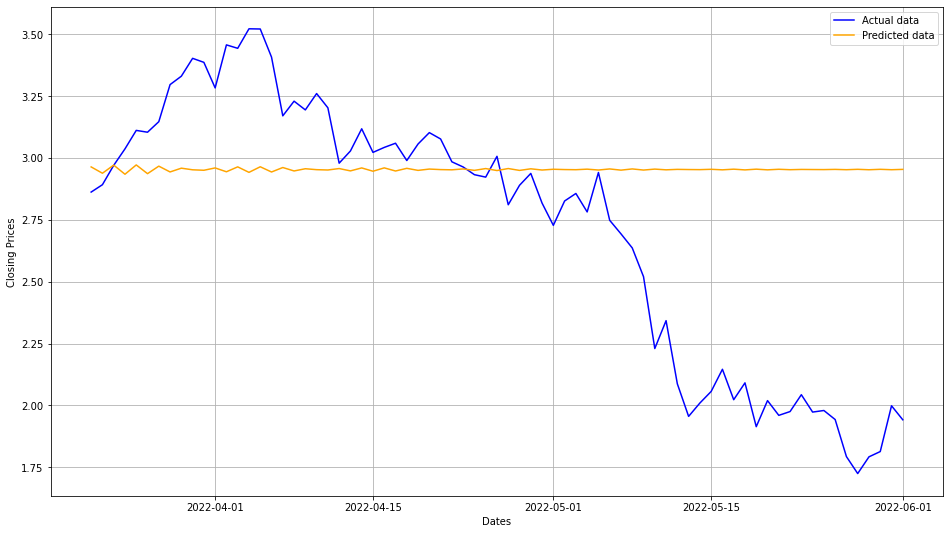

In [28]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [29]:
actual = column_or_1d(test)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


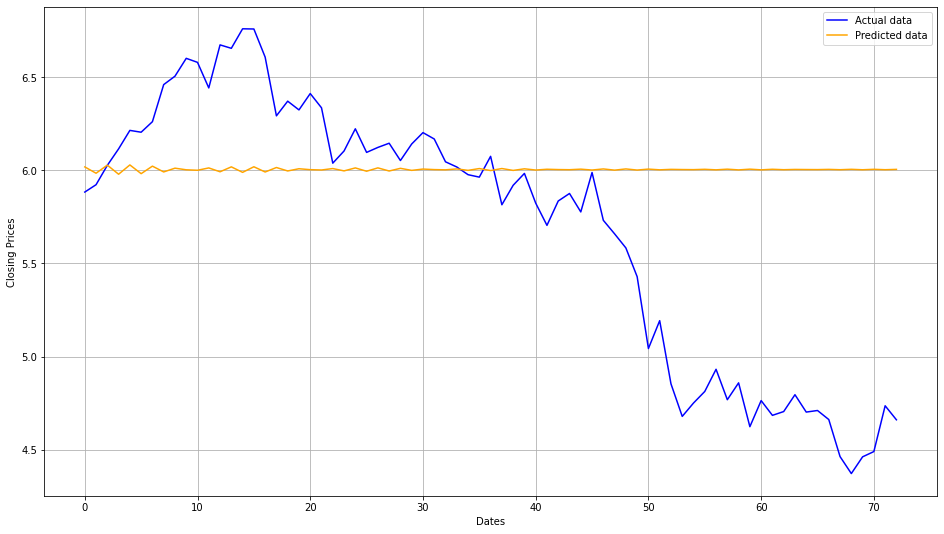

In [30]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_actual, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [31]:
# mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_actual, inv_pred)

# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MAPE: 11.42%
RMSE: 0.78
R2: -0.19
